Data shape: (1000, 3)
Iteration 00  Log-likelihood = -8814.5235
Iteration 01  Log-likelihood = -7890.5347
Iteration 02  Log-likelihood = -7821.5219
Iteration 03  Log-likelihood = -7791.6310
Iteration 04  Log-likelihood = -7775.4437
Iteration 05  Log-likelihood = -7766.2727
Iteration 06  Log-likelihood = -7760.1576
Iteration 07  Log-likelihood = -7754.5617
Iteration 08  Log-likelihood = -7749.1864
Iteration 09  Log-likelihood = -7744.3051
Iteration 10  Log-likelihood = -7740.3553
Iteration 11  Log-likelihood = -7737.4225
Iteration 12  Log-likelihood = -7736.0977
Iteration 13  Log-likelihood = -7735.2652
Iteration 14  Log-likelihood = -7734.6334
Iteration 15  Log-likelihood = -7734.0118
Iteration 16  Log-likelihood = -7733.1779
Iteration 17  Log-likelihood = -7731.9476
Iteration 18  Log-likelihood = -7730.1370
Iteration 19  Log-likelihood = -7727.6369
Iteration 20  Log-likelihood = -7725.7550
Iteration 21  Log-likelihood = -7724.4104
Iteration 22  Log-likelihood = -7723.1248
Iteration 23

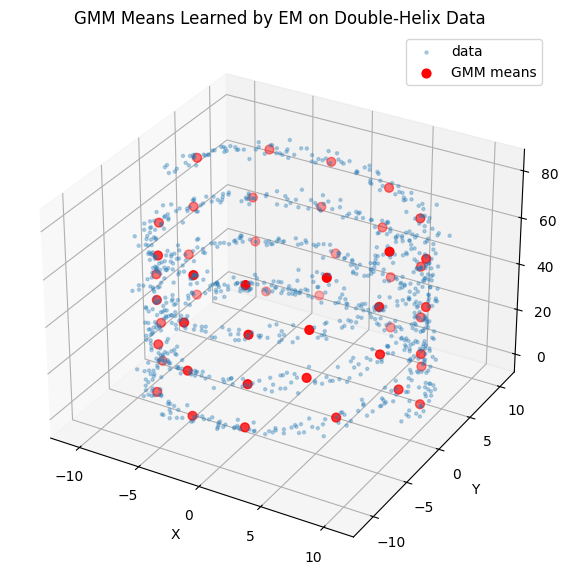

In [3]:
import numpy as np
import matplotlib.pyplot as plt


# 1. Load Data


data = np.loadtxt("double_helix_data_1000.csv", delimiter=",", skiprows=1)
X = data
N, D = X.shape
print("Data shape:", X.shape)


# 2. Double Helix Geometry


H = 80.0
r = 10.0
a = H / (4*np.pi)
K = 48

def helix1(theta):
    """Helix 1 center line."""
    return np.vstack([r*np.cos(theta),
                      r*np.sin(theta),
                      a*theta]).T

def helix2(theta):
    """Helix 2 center line (shifted by pi)."""
    return np.vstack([r*np.cos(theta + np.pi),
                      r*np.sin(theta + np.pi),
                      a*theta]).T

def local_frame(theta):
    """Orthonormal basis (tangent, radial, binormal) at angle theta."""
    t = np.array([-r*np.sin(theta), r*np.cos(theta), a], dtype=float)
    t_hat = t / np.linalg.norm(t)

    r_hat = np.array([np.cos(theta), np.sin(theta), 0.0])
    b_hat = np.cross(t_hat, r_hat)
    b_hat /= np.linalg.norm(b_hat)

    return t_hat, r_hat, b_hat

def build_cov(theta):
    """Build covariance aligned to helix direction."""
    t_hat, r_hat, b_hat = local_frame(theta)
    R = np.column_stack([t_hat, r_hat, b_hat])
    Dloc = np.diag([3.0**2, 1.0**2, 1.0**2])  # elongated along tangent
    return R @ Dloc @ R.T

# 3. Initialize GMM Parameters

means = np.zeros((K, D))
covs  = np.zeros((K, D, D))
pis   = np.full(K, 1.0/K)

theta_j = (4*np.pi/24) * (np.arange(24) + 0.5)

# Helix 1 components (0–23)
means[:24] = helix1(theta_j)
for i, th in enumerate(theta_j):
    covs[i] = build_cov(th)

# Helix 2 components (24–47)
means[24:] = helix2(theta_j)
for i, th in enumerate(theta_j, 24):
    covs[i] = build_cov(th)

# 4. Gaussian PDF

def gaussian_pdf(x, mu, Sigma):
    D = mu.size
    diff = x - mu
    try:
        L = np.linalg.cholesky(Sigma)
    except np.linalg.LinAlgError:
        Sigma += 1e-6 * np.eye(D)
        L = np.linalg.cholesky(Sigma)

    inv_L = np.linalg.inv(L)
    inv_Sigma = inv_L.T @ inv_L
    det_Sigma = np.prod(np.diag(L))**2

    exponent = -0.5 * np.sum(diff @ inv_Sigma * diff, axis=1)
    return (1.0 / np.sqrt((2*np.pi)**D * det_Sigma)) * np.exp(exponent)

# 5. EM Algorithm


def EM(X, means, covs, pis, iterations=50):
    N, D = X.shape
    K = len(pis)
    loglik = []

    for it in range(iterations):
        resp = np.zeros((N, K))
        for k in range(K):
            resp[:, k] = pis[k] * gaussian_pdf(X, means[k], covs[k])

        resp_sum = resp.sum(axis=1, keepdims=True)
        resp /= resp_sum
        loglik.append(np.sum(np.log(resp_sum)))

        print(f"Iteration {it:02d}  Log-likelihood = {loglik[-1]:.4f}")

        Nk = resp.sum(axis=0)

        pis = Nk / N

        for k in range(K):
            means[k] = (resp[:, k][:, None] * X).sum(axis=0) / Nk[k]

        for k in range(K):
            diff = X - means[k]
            cov = (resp[:, k][:, None] * diff).T @ diff / Nk[k]
            cov += 1e-6*np.eye(D)
            covs[k] = cov

    return means, covs, pis, loglik

# 6. Run EM

means_final, covs_final, pis_final, loglik = EM(X, means, covs, pis, iterations=30)


# 7. Visualization


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X[:,0], X[:,1], X[:,2], s=5, alpha=0.3, label='data')

ax.scatter(means_final[:,0], means_final[:,1], means_final[:,2],
           color='red', s=40, label='GMM means')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("GMM Means Learned by EM on Double-Helix Data")
ax.legend()
plt.show()
